DETEKSI EMOSI

In [1]:
# pip install tensorflow tqdm

IMPORT LIBRARRY

In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import cv2
from hashlib import md5
from tqdm import tqdm
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from sklearn.model_selection import train_test_split

EKSPLORASI DATASET

In [3]:
dataset_path = 'data_wajah'
class_names = sorted(os.listdir(dataset_path))

class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in class_names}
print("Jumlah gambar per kelas:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Jumlah gambar per kelas:
testing: 7
training: 7


In [4]:
dataset_path = 'data_wajah/training'
class_names = sorted(os.listdir(dataset_path))

class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in class_names}
print("Jumlah gambar pada training:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Jumlah gambar pada training:
angry: 7853
disgust: 7945
fear: 7806
happy: 7871
neutral: 7902
sad: 7886
surprise: 7498


In [5]:
dataset_path = 'data_wajah/testing'
class_names = sorted(os.listdir(dataset_path))

class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in class_names}
print("Jumlah gambar pada testing:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Jumlah gambar pada testing:
angry: 1800
disgust: 1800
fear: 1800
happy: 1800
neutral: 1800
sad: 1800
surprise: 1800


In [6]:
#augmentasi data training
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

import os
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

def augment_images(class_dir, target_count):
    images = os.listdir(class_dir)
    current_count = len(images)
    i = 0
    while current_count < target_count:
        img_path = os.path.join(class_dir, images[i % len(images)])
        img = load_img(img_path, color_mode="grayscale")
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        for batch in datagen.flow(x, batch_size=1):
            save_img(os.path.join(class_dir, f"aug_{i}.jpg"), batch[0])
            current_count += 1
            i += 1
            if current_count >= target_count:
                break

base_dir = "data_wajah/train"
target = 8000  # jumlah target yang diinginkan

for label in os.listdir(base_dir):
    augment_images(os.path.join(base_dir, label), target)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data_wajah/train'

In [ ]:
#augmentasi data testing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
import os
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

def augment_images(class_dir, target_count):
    images = os.listdir(class_dir)
    current_count = len(images)
    i = 0
    while current_count < target_count:
        img_path = os.path.join(class_dir, images[i % len(images)])
        img = load_img(img_path, color_mode="grayscale")
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        for batch in datagen.flow(x, batch_size=1):
            save_img(os.path.join(class_dir, f"aug_{i}.jpg"), batch[0])
            current_count += 1
            i += 1
            if current_count >= target_count:
                break

base_dir = "data_wajah/test"
target = 1800  # jumlah target yang diinginkan

for label in os.listdir(base_dir):
    augment_images(os.path.join(base_dir, label), target)


bagi menjadi 80:20

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Folder asal dan tujuan
training_dir = 'data_wajah/training'
testing_dir = 'data_wajah/testing'

# Ambil semua path gambar dari subfolder
image_files = []
for root, _, files in os.walk(training_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, file))

# Bagi data menjadi 80% training, 20% testing
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Pindahkan test files ke folder testing (preserve subfolder/label)
for file_path in test_files:
    # Ambil nama subfolder (misalnya 'stres' atau 'normal')
    rel_path = os.path.relpath(file_path, training_dir)
    label = os.path.dirname(rel_path)
    
    # Buat folder target jika belum ada
    dest_dir = os.path.join(testing_dir, label)
    os.makedirs(dest_dir, exist_ok=True)
    
    # Pindahkan file
    dest_path = os.path.join(dest_dir, os.path.basename(file_path))
    shutil.move(file_path, dest_path)

print(f"Total gambar ditemukan: {len(image_files)}")
print(f"Training tersisa: {len(train_files)}")
print(f"Testing dipindahkan: {len(test_files)}")


Total gambar ditemukan: 54761
Training tersisa: 43808
Testing dipindahkan: 10953


VISUALISASI DISTRIBUSI DATA 

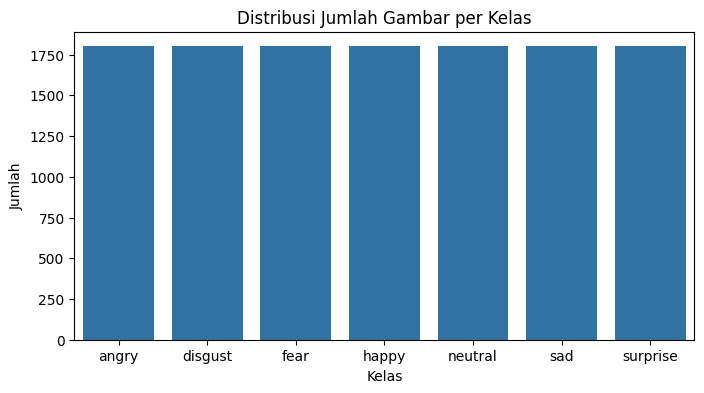

In [8]:
plt.figure(figsize=(8,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

CEK DAN HAPUS DATA DUPLIKAT

In [ ]:
def find_duplicates(folder):
    hash_dict = {}
    duplicates = []

    for subdir in os.listdir(folder):
        subfolder = os.path.join(folder, subdir)
        for filename in os.listdir(subfolder):
            path = os.path.join(subfolder, filename)
            with open(path, 'rb') as f:
                img_hash = md5(f.read()).hexdigest()
                if img_hash in hash_dict:
                    duplicates.append(path)
                else:
                    hash_dict[img_hash] = path
    return duplicates

duplicates = find_duplicates(dataset_path)
print(f"Jumlah gambar duplikat ditemukan: {len(duplicates)}")
for dup in duplicates:
    os.remove(dup)

Jumlah gambar duplikat ditemukan: 1236


MENGHAPUS GAMBAR NIOIS (BURAM ATAU KECIL)

In [ ]:
def is_noisy_image(img_path, min_size=(40,40)):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None or img.shape[0] < min_size[0] or img.shape[1] < min_size[1]:
            return True
        laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
        return laplacian_var < 10  # threshold blur
    except:
        return True

noisy_images = []
for cls in class_names:
    folder = os.path.join(dataset_path, cls)
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        if is_noisy_image(path):
            noisy_images.append(path)

print(f"Gambar noisy ditemukan: {len(noisy_images)}")
for img_path in noisy_images:
    os.remove(img_path)

Gambar noisy ditemukan: 3


MEMPERSIAPKAN DATA

In [9]:
img_size = (48, 48)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=15
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 17992 images belonging to 7 classes.
Found 4494 images belonging to 7 classes.


PEMODELAN CNN

In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\ahmadalbani\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

TRAINING MODEL

In [11]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights
)

Epoch 1/20


c:\Users\ahmadalbani\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


563/563 ━━━━━━━━━━━━━━━━━━━━ 283s 492ms/step - accuracy: 0.4537 - loss: 1.4119 - val_accuracy: 0.3376 - val_loss: 1.9240
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step - accuracy: 0.6771 - loss: 0.8521 - val_accuracy: 0.3721 - val_loss: 1.9182
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - accuracy: 0.6983 - loss: 0.7847 - val_accuracy: 0.3781 - val_loss: 1.9250
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.7089 - loss: 0.7448 - val_accuracy: 0.3930 - val_loss: 1.8215
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 36s 63ms/step - accuracy: 0.7162 - loss: 0.7156 - val_accuracy: 0.4226 - val_loss: 1.8304
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 35s 62ms/step - accuracy: 0.7278 - loss: 0.6999 - val_accuracy: 0.4270 - val_loss: 1.8787
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.7310 - loss: 0.6846 - val_accuracy: 0.4384 - val_loss: 1.8502
Epoch 8/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 33s 58ms/step - accuracy: 0.7375 - loss: 0.6783 - val_accur

EVALUASI & CONFUSION MATRIX

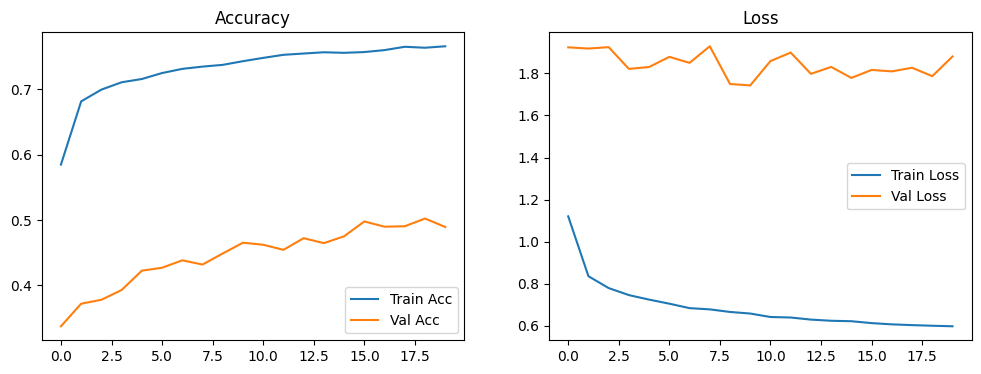

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

Confusion Matrix

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.15      0.12      0.13       650
     disgust       0.11      0.07      0.09       605
        fear       0.15      0.04      0.07       638
       happy       0.15      0.27      0.19       663
     neutral       0.16      0.20      0.18       662
         sad       0.14      0.17      0.15       650
    surprise       0.14      0.10      0.12       626

    accuracy                           0.14      4494
   macro avg       0.14      0.14      0.13      4494
weighted avg       0.14      0.14      0.13      4494



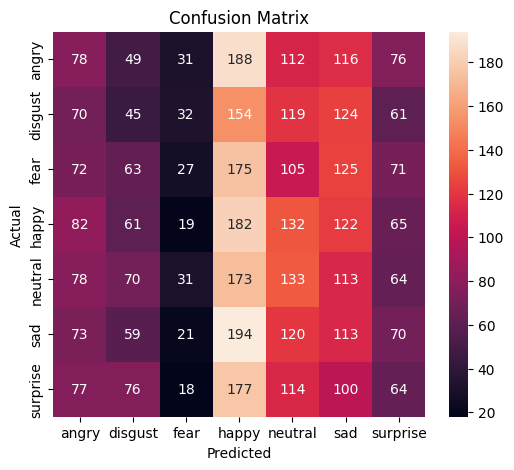

In [13]:
val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# pip install opencv-python tensorflow numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


LOAD MODE CNN

In [14]:
model.save("model_stres.h5")

In [15]:
model = load_model("model_stres.h5")

In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Muat model dan label klasifikasi
model = load_model("model_stres.h5")
class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Muat Haar Cascade untuk deteksi wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Ukuran canvas tampilan (hitam)
canvas_width = 800
canvas_height = 600

# Buka kamera
cap = cv2.VideoCapture(1)
if not cap.isOpened():
    print("❌ Tidak bisa mengakses kamera.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("❌ Gagal membaca frame dari kamera.")
        continue

    # Resize frame ke 512x384
    frame_resized = cv2.resize(frame, (512, 384))
    gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Ekstrak dan preprocess wajah
        face_img = gray[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (48, 48))
        face_img = face_img / 255.0
        face_img = np.expand_dims(face_img, axis=-1)
        face_img = np.expand_dims(face_img, axis=0)

        # Prediksi
        pred = model.predict(face_img)
        label = class_labels[np.argmax(pred)]

        # Gambar kotak dan label
        cv2.rectangle(frame_resized, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame_resized, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.9, (0, 255, 0), 2)

    # Buat canvas hitam
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    # Hitung posisi tengah
    x_offset = (canvas_width - frame_resized.shape[1]) // 2
    y_offset = (canvas_height - frame_resized.shape[0]) // 2

    # Tempel frame ke canvas
    canvas[y_offset:y_offset+frame_resized.shape[0], x_offset:x_offset+frame_resized.shape[1]] = frame_resized

    # Tampilkan
    cv2.imshow("Deteksi Emosi/Stres - Tekan 'q' untuk keluar", canvas)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━